# Predviđanje broja gostiju na dnevnoj, tjodnoj i jesečnoj bazi koristeći statistički model ARIMA

**Rezultati** 
- Hotel booking demand dataset
    - Dnevne predikcije
        - Test MAPE City Hotel: xx
        - Test MAPE Resort Hotel: xx
    - Tjedne predikcije
        - Test MAPE City Hotel: xx
        - Test MAPE Resort Hotel: xx
    - Mjesečne predikcije
        - Test MAPE City Hotel: xx
        - Test MAPE Resort Hotel: xx

- Lumen dataset `data/interim/data_wo_cancel.parquet`
- Hotel 0 dataset `data/interim/data_wo_cancel_hotel0.parquet`
- Hotel 1 dataset `data/interim/data_wo_cancel_hotel1.parquet`

# Učitavanje modula

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error
import os

for dirname, _, filenames in os.walk('..\\data\\raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

..\data\raw\export_df.parquet


# Učitavanje podataka 

In [4]:
DATA_WO_CANCELLATIONS_PATH = '../data/interim/data_wo_cancel.parquet'
DATA_HOTEL0_PATH = '../data/interim/data_wo_cancel_hotel0.parquet'
DATA_HOTEL1_PATH = '../data/interim/data_wo_cancel_hotel1.parquet'


In [14]:
data = pd.read_parquet(DATA_WO_CANCELLATIONS_PATH)
dataResort = pd.read_parquet(DATA_HOTEL0_PATH)
dataCity = pd.read_parquet(DATA_HOTEL1_PATH)
data.head()

,hotel_id,datum_dolaska,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,gost_id,duljina_boravka,ukupno_gostiju,raspon_dolazak_rezervacija
0,0,2015-07-01,PRT,0,0,100.000000,1077152,0,2.0,161
1,0,2015-07-01,PRT,0,0,100.000000,1017906,0,2.0,21
2,0,2015-07-01,GBR,0,1,64.991345,1039896,1,1.0,49
3,0,2015-07-01,GBR,1,1,74.368897,1008245,1,1.0,397
4,0,2015-07-01,GBR,2,1,130.973278,1093703,2,2.0,360


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74553 entries, 0 to 74552
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   hotel_id                    74553 non-null  int32         
 1   datum_dolaska               74553 non-null  datetime64[ns]
 2   zemlja_gosta                74553 non-null  object        
 3   kanal_prodaje_id            74553 non-null  int32         
 4   tip_sobe_id                 74553 non-null  int32         
 5   cijena_nocenja              74553 non-null  float64       
 6   gost_id                     74553 non-null  int32         
 7   duljina_boravka             74553 non-null  int64         
 8   ukupno_gostiju              74553 non-null  float64       
 9   raspon_dolazak_rezervacija  74553 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(1)
memory usage: 4.6+ MB


In [9]:
NaN = data.isna().sum()
NaN

hotel_id                      0
datum_dolaska                 0
zemlja_gosta                  0
kanal_prodaje_id              0
tip_sobe_id                   0
cijena_nocenja                0
gost_id                       0
duljina_boravka               0
ukupno_gostiju                0
raspon_dolazak_rezervacija    0
dtype: int64

### Dodavanje ciljane varijable - ukupan broj gostiju u nekom periodu, na dnevnoj, tjednoj, mjesečnoj i godišnjoj razini

### City Hotel

#### Dnevna razina

In [15]:
NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()
org_len = len(NumberOfGuestsDailyCity)
NumberOfGuestsDailyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-01,10.0
2015-01-02,6.0
2015-01-03,11.0
2015-01-04,8.0
2015-01-05,4.0


#### Tjedna razina

In [17]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('W').sum().to_frame()
org_len = len(NumberOfGuestsWeeklyCity)
NumberOfGuestsWeeklyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-04,35.0
2015-01-11,42.0
2015-01-18,54.0
2015-01-25,48.0
2015-02-01,27.0


#### Mjesečna razina

In [18]:
NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity .resample('ME').sum().to_frame()
org_len = len(NumberOfGuestsMonthlyCity)
NumberOfGuestsMonthlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-31,206.0
2015-02-28,0.0
2015-03-31,0.0
2015-04-30,0.0
2015-05-31,1072.0


#### Godišnja razina

In [21]:
NumberOfGuestsYearlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsYearlyCity = NumberOfGuestsYearlyCity.resample('y').sum().to_frame()
NumberOfGuestsYearlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,13723.0
2016-12-31,44405.0
2017-12-31,31254.0


#### Problemi s anomalija kod City Hotela (npr. 0 gostiju u nekim danima)

In [33]:
indexes = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days > 1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

for start, end in periods:
    print(f"Periodi gdje je broj gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days} dana")

Periodi gdje je broj gostiju jednak nuli : od 2015-02-01 do 2015-04-30, ukupno 88 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-06-01 do 2015-06-30, ukupno 29 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-05 do 2015-07-06, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-12 do 2015-07-14, ukupno 2 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-19 do 2015-07-19, ukupno 0 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-21 do 2015-07-21, ukupno 0 dana
Periodi gdje je broj gostiju jednak nuli : od 2017-09-01 do 2017-09-30, ukupno 29 dana


ZAKLJUČAK
- dio podataka gdje je duljina perioda gdje hotel nema gostiju dulja od tjedan dana ima smisla izbaciti, zajedno s podacima koji prethode, ako govorimo o "malom "uzorku "čistih" podataka koji prethode dugim anomalijama
- kako je taj "mali" uzorak podataka koji smijemo izbaciti arbitraran, moguće je modelirati na više načina, s većom/manjom količinom izbacivanja podataka
- manje periode ima smisla modelirati na način da se agregiraju srednje vrijednosti podatka iz susjedstva (npr. tjedan dana prije i poslije) ili interpolirati srednje vrijednosti iz susjedstva
- prethodno može biti primjenjemo na dulje periode, ukoliko je potrebno
- ARIMA model, kao i MAPE metrika, ne reagiraju dobro na anomalije, odnosno MAPE puca (zbog djeljenja s nulom) ako su ciljani podaci nula, odnosno u ovom slučaju za svaki slučaj kada je broj ukupnih gosti na bilo kojoj vremenskoj bazi jednak nuli


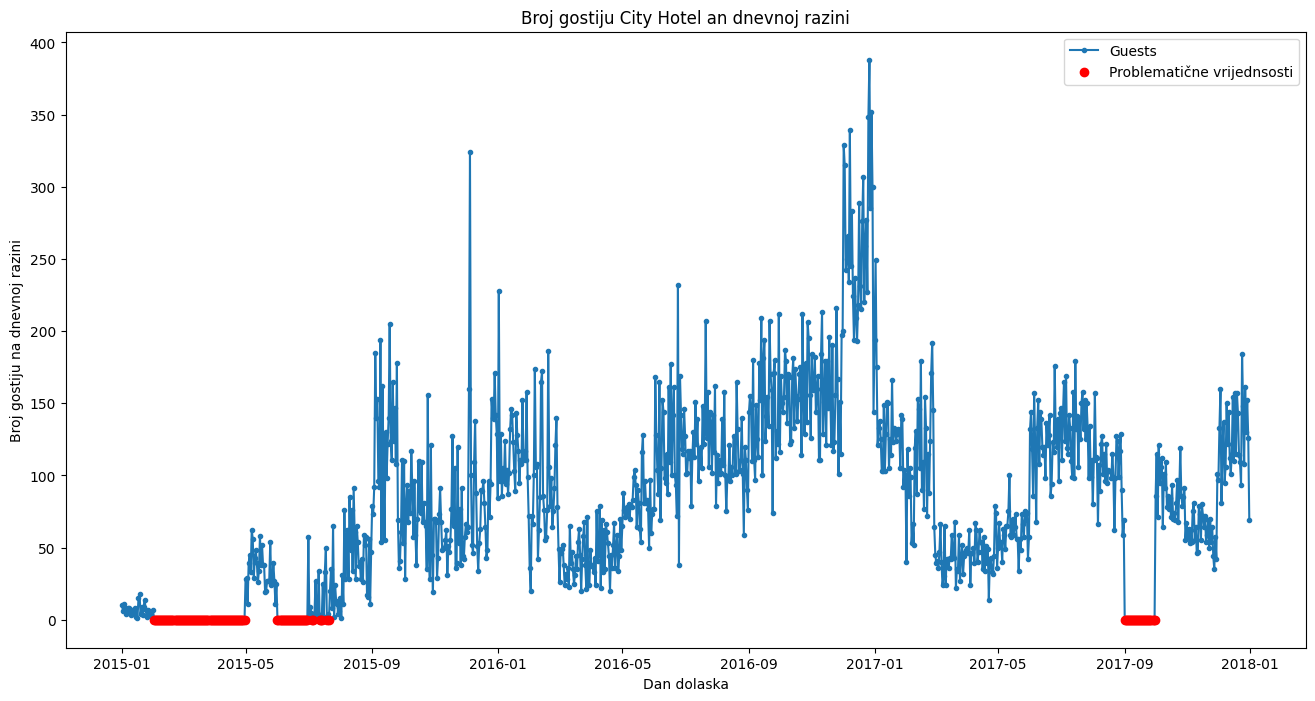

In [37]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker='.', label='Guests')
plt.plot(NumberOfGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednsosti')

plt.title('Broj gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

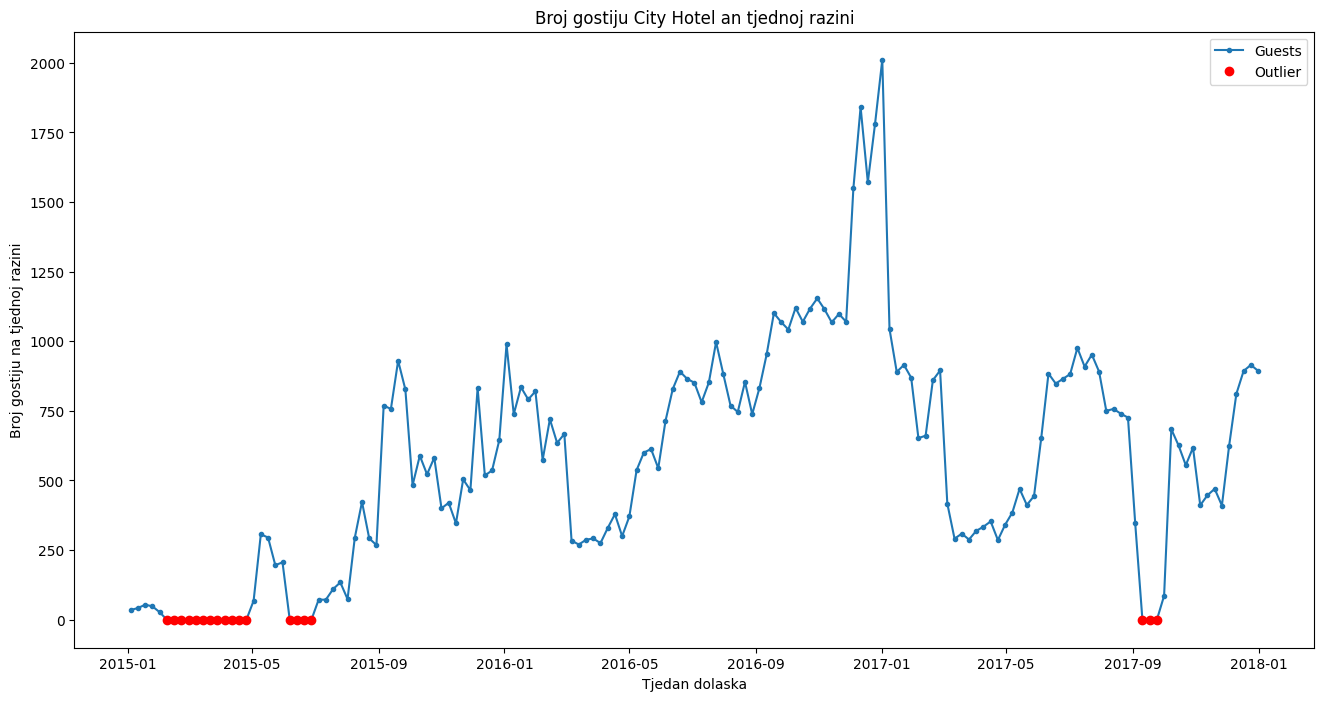

In [42]:
weekly_indexes = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['ukupno_gostiju'] == 0].index
outliers_weekly = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity.index.isin(weekly_indexes)]

plt.figure(figsize=(16, 8))
plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Guests')
plt.plot(outliers_weekly['ukupno_gostiju'], 'o', color='red', label='Outlier')
plt.title('Broj gostiju City Hotel an tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')
plt.legend()
plt.show()

In [ ]:

rolling_mean_daily = NumberOfGuestsDailyCity['ukupno_gostiju'].rolling(window=4, min_periods=1).mean()

for idx in NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] == 0].index:
    NumberOfGuestsDailyCity.at[idx, 'ukupno_gostiju'] = rolling_mean_daily[idx]

new_len = len(NumberOfGuestsDailyCity)

assert new_len == org_len


#### OPCIONALNO

In [ ]:
rolling_mean_weekly = NumberOfGuestsWeeklyCity['ukupno_gostiju'].rolling(window=4, min_periods=1).mean()

for idx in NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['ukupno_gostiju'] == 0].index:
    NumberOfGuestsWeeklyCity.at[idx, 'ukupno_gostiju'] = rolling_mean_weekly[idx]

new_len = len(NumberOfGuestsWeeklyCity)

assert new_len == org_len


#### OPCIONALNO

In [ ]:
rolling_mean_monthly = NumberOfGuestsMonthlyCity['ukupno_gostiju'].rolling(window=4, min_periods=1).mean()

for idx in NumberOfGuestsMonthlyCity[NumberOfGuestsMonthlyCity['ukupno_gostiju'] == 0].index:
    NumberOfGuestsMonthlyCity.at[idx, 'ukupno_gostiju'] = rolling_mean_monthly[idx]

new_len = len(NumberOfGuestsMonthlyCity)

assert new_len == org_len
NumberOfGuestsMonthlyCity.head(5)

### Resort Hotel

In [20]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head()

,ukupno_gostiju
datum_dolaska,
2015-07-01,67.0
2015-07-02,72.0
2015-07-03,59.0
2015-07-04,80.0
2015-07-05,80.0


#### Dnevna razina

In [22]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-01,67.0
2015-07-02,72.0
2015-07-03,59.0
2015-07-04,80.0
2015-07-05,80.0


#### Tjedna razina

In [23]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()
NumberOfGuestsWeeklyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-05,358.0
2015-07-12,495.0
2015-07-19,537.0
2015-07-26,533.0
2015-08-02,554.0


#### Mjesečna razina

In [24]:
NumberOfGuestsMonthlyResort =  dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort = NumberOfGuestsMonthlyResort.resample('m').sum().to_frame()
NumberOfGuestsMonthlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-31,2300.0
2015-08-31,2318.0
2015-09-30,2013.0
2015-10-31,2108.0
2015-11-30,1534.0


#### Godišnja razina

In [25]:
NumberOfGuestsYearlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsYearlyResort = NumberOfGuestsYearlyResort.resample('y').sum().to_frame()
NumberOfGuestsYearlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,12053.0
2016-12-31,26091.0
2017-12-31,17816.0


# ARIMA model za predviđanje budućeg broja gostiju - City Hotel

## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

##### Augmented Dickey-Fuller (ADF) test se koristi u statistici i ekonometriji za testiranje prisutnosti tzv. "jediničnog korijena" (unit root) u vremenskim serijama
##### Jedinični korijen ukazuje na to da vremenska serija nije stacionarna, što znači da njene statističke karakteristike kao što su srednja vrijednost, varijanca i autokorelacija, se mijenjaju tijekom vremena
##### Nulta hipoteza (H0): Postoji jedinični korijen, tj. serija je nestacionarna.
##### Alternativna hipoteza (H1): Ne postoji jedinični korijen, tj. serija je stacionarna.

In [ ]:
CityDailyValues = NumberOfGuestsDailyCity.values
result_city_daily = adfuller(CityDailyValues)
print('ADF Statistic: %f' % result_city_daily[0])
print('p-value: %f' % result_city_daily[1])
print('Critical Values:')
for key, value in result_city_daily[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veča od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_city_daily = NumberOfGuestsDailyCity.rolling(window=4).mean()
rolling_std_city_daily = NumberOfGuestsDailyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_daily, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_daily, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela nd dnevnoj razini')
plt.show()

#### Train / test split podataka

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_city_daily = int(len(NumberOfGuestsDailyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_daily} podataka, test {len(NumberOfGuestsDailyCity)-train_test_split_city_daily} podataka")

trainCityDaily = NumberOfGuestsDailyCity[:train_test_split_city_daily]
testCityDaily = NumberOfGuestsDailyCity[train_test_split_city_daily:]

#### Fit ARIMA modela na podatke na dnevnoj bazi

- Iz službene dokumentacije (https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period):
   - The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:
    - 7 - daily
    - 12 - monthly
    - 52 - weekly

- parametar 'd' koristi se ako je potrebno diferencirati vremensku seriju, odnosno postavljamo ga na None ako ne znamo kako diferencirati podatke,
a inače na int vrijednost (tipično 1). Zaklkučak o tome izvodimo iz Augmented Dickey-Fuller Test koji testira jesu li neki podaci u vremenskoj seriji 
stacionarni ili nisu

- Vremenska je serija stacionarna kada su joj  medijan, varijanca, auto-korelacija i slične metrike konstante kroz vrijeme t.
ARIMA pretpostavlja da podaci postaju stacionarni nako diferenciranja, ukoliko je d postavljen an vrijednost veću od nule, što
se naziva diferencijablna stacionarnost. auto_arima određuje i optimalni d.

In [ ]:
stepwise_fit_city_daily = auto_arima(trainCityDaily['ukupno_gostiju'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5, m=7,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_daily.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,4)(1,1,1)[7]   je najbolji model te se to preslikava u parametre
- order = (1,0,4)
- seasonal_order = (1,1,1,7)

In [ ]:
modelCity_daily = ARIMA(trainCityDaily['ukupno_gostiju'],
                  order=(1, 0, 4),
                  seasonal_order=(1, 1, 1, 7))

resultCity_daily = modelCity_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [ ]:
predictionsCityTestDaily = resultCity_daily.predict(train_test_split_city_daily, train_test_split_city_daily + len(testCityDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela na dnevnoj bazi', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrCityDaily_test = mean_absolute_percentage_error(testCityDaily, predictionsCityTestDaily)
print('Test MAPE City Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrCityDaily_test)

## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [ ]:
CityWeeklyValues = NumberOfGuestsWeeklyCity.values
result_city_weekly = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city_weekly[0])
print('p-value: %f' % result_city_weekly[1])
print('Critical Values:')
for key, value in result_city_weekly[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_city_weekly = NumberOfGuestsWeeklyCity.rolling(window=4).mean()
rolling_std_city_weekly = NumberOfGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela na tjednoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_city_weekly = int(len(NumberOfGuestsWeeklyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_weekly} podataka, test {len(NumberOfGuestsWeeklyCity)-train_test_split_city_weekly} podataka")

trainCityWeekly = NumberOfGuestsWeeklyCity[:train_test_split_city_weekly]
testCityWeekly = NumberOfGuestsWeeklyCity[train_test_split_city_weekly:]

#### Fit ARIMA modela na podatke na tjednoj bazi

In [ ]:
stepwise_fit_city_weekly = auto_arima(trainCityWeekly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=52,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_weekly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,1,0)(0,1,0)[52] je najbolji model te se to preslikava u parametre
- order = (0,1,0)
- seasonal_order = (0,1,0,52)

In [ ]:
modelCityWeekly = ARIMA(trainCityWeekly['ukupno_gostiju'],
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 0, 52))

resultCityWeekly = modelCityWeekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [ ]:
predictionsCityTestWeekly = resultCityWeekly.predict(train_test_split_city_weekly, train_test_split_city_weekly + len(testCityWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na tjednoj razini

In [ ]:
plt.figure(figsize=(15, 8))
trainCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrCityWeekly_test = mean_absolute_percentage_error(testCityWeekly, predictionsCityTestWeekly)
print('Test MAPE City Hotel tjedna razina: %f' % MeanAbsPercentageErrCityWeekly_test)

## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnombroju gostiju

In [ ]:
CityMonthlyValues = NumberOfGuestsMonthlyCity.values
result_city_monthly = adfuller(CityMonthlyValues)
print('ADF Statistic: %f' % result_city_monthly [0])
print('p-value: %f' % result_city_monthly [1])
print('Critical Values:')
for key, value in result_city_monthly [4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela Mjesečna razina

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_city_monthly  = NumberOfGuestsMonthlyCity.rolling(window=4).mean()
rolling_std_city_monthly = NumberOfGuestsMonthlyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela na mjesečnoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_city_monthly = int(len(NumberOfGuestsMonthlyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_monthly} podataka, test {len(NumberOfGuestsMonthlyCity)-train_test_split_city_monthly} podataka")

trainCityMonthly = NumberOfGuestsMonthlyCity[:train_test_split_city_monthly]
testCityMonthly = NumberOfGuestsMonthlyCity[train_test_split_city_monthly:]

#### Fit ARIMA modela na podatke na mjesečnoj bazi

In [ ]:
stepwise_fit_city_monthly = auto_arima(trainCityMonthly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_monthly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,0)(0,1,0)[12] je najbolji model te se to preslikava u parametre
- order = (1,0,0)
- seasonal_order = (0,1,0,12)

In [ ]:
modelCityMonthly = ARIMA(trainCityMonthly['ukupno_gostiju'],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultCityMonthly = modelCityMonthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [ ]:
predictionsCityTestMonthly = resultCityMonthly.predict(train_test_split_city_monthly, train_test_split_city_monthly + len(testCityMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na mjesečnoj razini

In [ ]:
plt.figure(figsize=(15, 8))
trainCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrCityMonthly_test = mean_absolute_percentage_error(testCityMonthly, predictionsCityTestMonthly)
print('Test MAPE City Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrCityMonthly_test)

# ARIMA model za predviđanje budućeg broja gostiju - Resort Hotel 


## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [ ]:
ResortDailyValues = NumberOfGuestsDailyResort.values
result_resort_daily = adfuller(ResortDailyValues)
print('ADF Statistic: %f' % result_resort_daily[0])
print('p-value: %f' % result_resort_daily[1])
print('Critical Values:')
for key, value in result_resort_daily[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na dnevnioj razini

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_daily = NumberOfGuestsDailyResort.rolling(window=4).mean()
rolling_std_resort_daily  = NumberOfGuestsDailyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_daily , color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_daily , color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na dnevnoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_resort_daily = int(len(NumberOfGuestsDailyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_daily} podataka, test {len(NumberOfGuestsDailyResort)-train_test_split_resort_daily} podataka")

trainResortDaily = NumberOfGuestsDailyResort[:train_test_split_resort_daily]
testResortDaily = NumberOfGuestsDailyResort[train_test_split_resort_daily:]

#### Fit ARIMA modela na podatke na dnevnoj bazi

In [ ]:
stepwise_fit_resort_daily = auto_arima(trainResortDaily['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_daily.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,1)(0,1,1)[7]    je najbolji model te se to preslikava u parametre
- order = (0, 0 ,1)
- seasonal_order = (0,1,1,7)


In [ ]:
modelResort_daily = ARIMA(trainResortDaily['ukupno_gostiju'],
                  order=(0, 0, 1),
                  seasonal_order=(0, 1, 1, 7))

resultResort_daily = modelResort_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [ ]:
predictionsResortTestDaily = resultResort_daily.predict(train_test_split_resort_daily, train_test_split_resort_daily + len(testResortDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju Resort Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija dnevnog broja gostiju kod Resort Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrResortDaily_test = mean_absolute_percentage_error(testResortDaily, predictionsResortTestDaily)
print('Test MAPE Resort Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrResortDaily_test)

## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o tjednom broju gostiju

In [ ]:
ResortWeeklyValues = NumberOfGuestsWeeklyResort.values
result_resort_weekly = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort_weekly [0])
print('p-value: %f' % result_resort_weekly [1])
print('Critical Values:')
for key, value in result_resort_weekly [4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na tjednoj razini

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_weekly = NumberOfGuestsWeeklyResort.rolling(window=4).mean()
rolling_std_resort_weekly = NumberOfGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na tjednoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_resort_weekly = int(len(NumberOfGuestsWeeklyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_weekly} podataka, test {len(NumberOfGuestsWeeklyResort)-train_test_split_resort_weekly} podataka")

trainResortWeekly = NumberOfGuestsWeeklyResort[:train_test_split_resort_weekly]
testResortWeekly = NumberOfGuestsWeeklyResort[train_test_split_resort_weekly:]

#### Fit ARIMA modela na podatke na tjednoj bazi

In [ ]:
stepwise_fit_resort_weekly = auto_arima(trainResortWeekly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=54,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_weekly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[54]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[54] 


In [ ]:
modelResort_weekly = ARIMA(trainResortWeekly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 54))

resultResort_weekly= modelResort_weekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [ ]:
predictionsResortTestWeekly = resultResort_weekly.predict(train_test_split_resort_weekly, train_test_split_resort_weekly + len(testResortWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrResortWeekly_test = mean_absolute_percentage_error(testResortWeekly, predictionsResortTestWeekly)
print('Test MAPE Resort Hotel na tjednoj razini: %f' % MeanAbsPercentageErrResortWeekly_test)

## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnom broju gostiju

In [ ]:
ResortMonthlyValues = NumberOfGuestsMonthlyResort.values
result_resort_monthly = adfuller(ResortMonthlyValues)
print('ADF Statistic: %f' % result_resort_monthly[0])
print('p-value: %f' % result_resort_monthly[1])
print('Critical Values:')
for key, value in result_resort_monthly[4].items():
    print('\t%s: %.3f' % (key, value))

- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manje od alfe, možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na mjesečnoj razini

In [ ]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_monthly = NumberOfGuestsMonthlyResort.rolling(window=4).mean()
rolling_std_resort_monthly = NumberOfGuestsMonthlyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na mjesečnoj razini')
plt.show()

In [ ]:
split_ratio  =  0.8

In [ ]:
train_test_split_resort_monthly = int(len(NumberOfGuestsMonthlyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_monthly} podataka, test {len(NumberOfGuestsMonthlyResort)-train_test_split_resort_monthly} podataka")

trainResortMonthly = NumberOfGuestsMonthlyResort[:train_test_split_resort_monthly]
testResortMonthly = NumberOfGuestsMonthlyResort[train_test_split_resort_monthly:]

In [ ]:
stepwise_fit_resort_monthly = auto_arima(trainResortMonthly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_monthly.summary()

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[12]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[12] 


In [ ]:
modelResort_monthly = ARIMA(trainResortMonthly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultResort_monthly= modelResort_monthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [ ]:
predictionsResortTestMonthly = resultResort_monthly.predict(train_test_split_resort_monthly, train_test_split_resort_monthly + len(testResortMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


In [ ]:
plt.figure(figsize=(15, 8))
testResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija Broja Gostiju Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
plt.figure(figsize=(15, 8))
trainResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [ ]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test)

## Pregled svih rezultata 

In [ ]:
errors_data = {
    'Hotel': ['City', 'City', 'City', 'Resort', 'Resort', 'Resort'],
    'Time Range': ['Daily', 'Weekly', 'Monthly', 'Daily', 'Weekly', 'Monthly'],
    'MeanAbsPercentageError/%': [
        MeanAbsPercentageErrCityDaily_test,
        MeanAbsPercentageErrCityWeekly_test,
        MeanAbsPercentageErrCityMonthly_test,
        MeanAbsPercentageErrResortDaily_test,
        MeanAbsPercentageErrResortWeekly_test,
        MeanAbsPercentageErrResortMonthly_test
    ]
}

errors_df = pd.DataFrame(errors_data)
errors_df = errors_df.style.format({'MeanAbsPercentageError': "{:.2f}"})

In [ ]:
errors_df